In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00


In [2]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np

from datasets import load_dataset

dataset = load_dataset('xnli', 'en')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [3]:
import os

os.system("""wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/_PuirqYsyj4sLw" -O XNLI_en""")

0

In [4]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
stete_dict = torch.load("./XNLI_en", map_location='cpu')
model.load_state_dict(stete_dict)

device = "cpu"
if torch.cuda.is_available(): device = "cuda"

model = model.to(device)

In [6]:
import random

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

def make_dataloader(dataset, n_samples=500):
    label_dict = {'contradiction': 0, 'entail': 1, 'neutral': 2}

    # Загрузка датасета
    # dataset = load_dataset('xnli', language, split='test')

    # Получение размера датасета
    dataset_size = len(dataset['label'])

    # Генерация случайных уникальных индексов для выборки
    random_indices = random.sample(range(dataset_size), n_samples)

    # Выборка данных по случайным индексам
    test = [f"[CLS] {dataset['premise'][i]} [SEP] {dataset['hypothesis'][i]} [SEP]" for i in random_indices]

    encoded_data_predict = tokenizer.batch_encode_plus(
        test,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_predict = encoded_data_predict['input_ids']
    attention_masks_predict = encoded_data_predict['attention_mask']
    labels_predict = torch.tensor([dataset['label'][i] for i in random_indices])

    dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)

    batch_size = 3

    return DataLoader(dataset_predict, sampler=SequentialSampler(dataset_predict), batch_size=batch_size)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [8]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

In [11]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [12]:
def eval_prediction(dataloader):
    label_dict = {'contradiction': 0, 'entail': 1, 'neutral': 2}

    predict_loss, predictions, true_predict = evaluate(dataloader)
    predict_f1 = f1_score_func(predictions, true_predict)
    print(f'Predictions loss: {predict_loss}')
    print(f'F1 Score (Weighted): {predict_f1}')
    plot_confusion_matrix(predictions, true_predict, label_dict)
    metrics_per_class(predictions, true_predict, label_dict)

ru
Predictions loss: 1.1165915864134976
F1 Score (Weighted): 0.5638108854839877


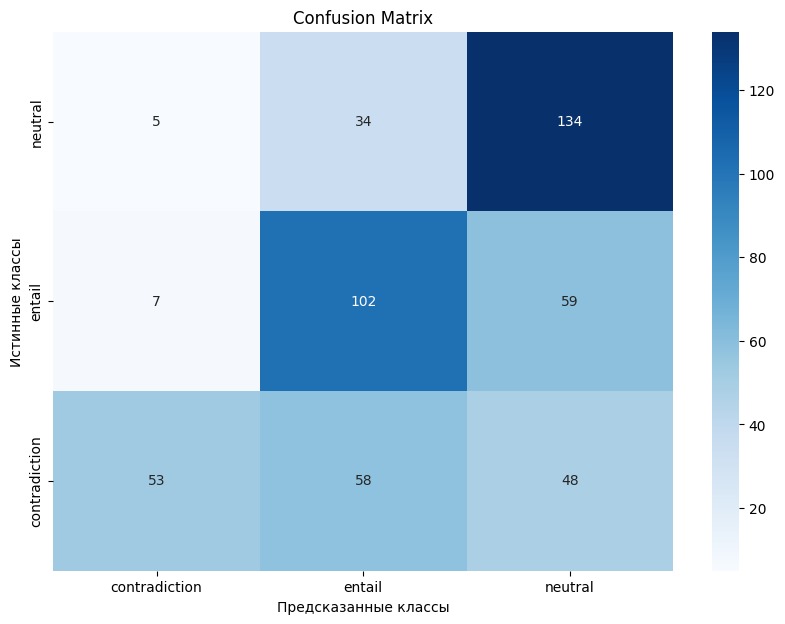

Class: contradiction
Accuracy: 53/159 (True Positives / Total Actual Positives)
Precision: 0.82
Recall: 0.33
F1 Score: 0.47

Class: entail
Accuracy: 102/168 (True Positives / Total Actual Positives)
Precision: 0.53
Recall: 0.61
F1 Score: 0.56

Class: neutral
Accuracy: 134/173 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.77
F1 Score: 0.65

fr


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions loss: 1.2079735714384539
F1 Score (Weighted): 0.5236114414996769


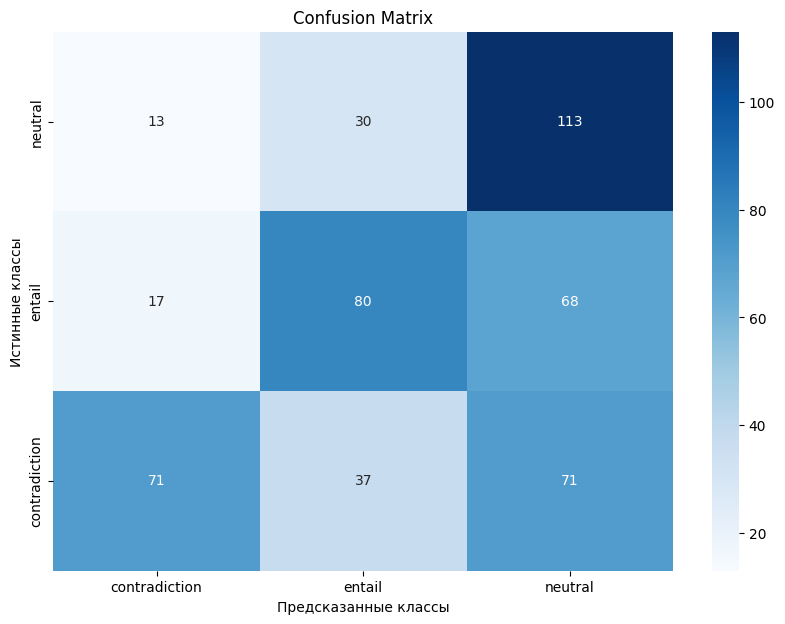

Class: contradiction
Accuracy: 71/179 (True Positives / Total Actual Positives)
Precision: 0.70
Recall: 0.40
F1 Score: 0.51

Class: entail
Accuracy: 80/165 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.48
F1 Score: 0.51

Class: neutral
Accuracy: 113/156 (True Positives / Total Actual Positives)
Precision: 0.45
Recall: 0.72
F1 Score: 0.55

hi


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions loss: 1.3069619179151193
F1 Score (Weighted): 0.45436111511887023


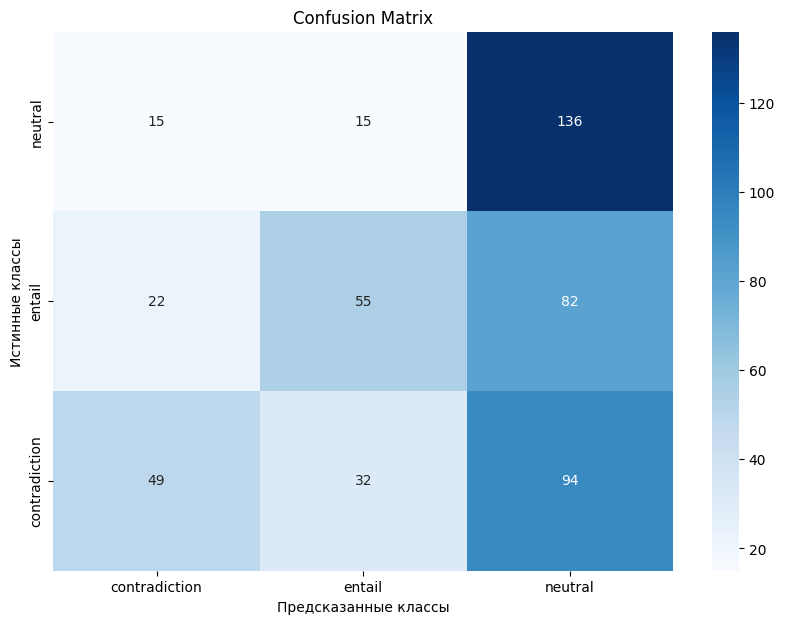

Class: contradiction
Accuracy: 49/175 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.28
F1 Score: 0.38

Class: entail
Accuracy: 55/159 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.35
F1 Score: 0.42

Class: neutral
Accuracy: 136/166 (True Positives / Total Actual Positives)
Precision: 0.44
Recall: 0.82
F1 Score: 0.57

ar


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions loss: 1.267906899313013
F1 Score (Weighted): 0.5316706039175925


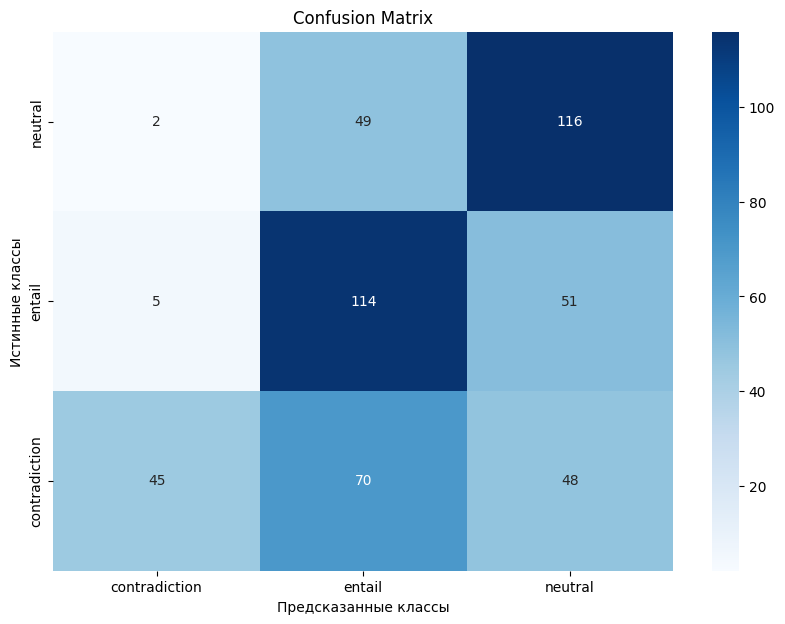

Class: contradiction
Accuracy: 45/163 (True Positives / Total Actual Positives)
Precision: 0.87
Recall: 0.28
F1 Score: 0.42

Class: entail
Accuracy: 114/170 (True Positives / Total Actual Positives)
Precision: 0.49
Recall: 0.67
F1 Score: 0.57

Class: neutral
Accuracy: 116/167 (True Positives / Total Actual Positives)
Precision: 0.54
Recall: 0.69
F1 Score: 0.61



In [13]:
for lang in ['ru', 'fr', 'hi', 'ar']:
    print(lang)
    dataset = load_dataset('xnli', lang, split='test')
    dataloader = make_dataloader(dataset)
    eval_prediction(dataloader)